# Задание

**Задание 1**

Есть таблица с товарами: items
```
item_id    name                 price       update_date
-------    ----------------     ------      -----------
1          Ручка гелевая        10          2020-02-01
2          Карандаш 1HH         2           2020-01-01
1          Ручка шариковая      10          2020-03-01
3          Ластик               5           2020-07-01
2          Карандаш 1HH         3           2020-05-01
1          Ручка шариковая      5           2020-05-01
2          Карандаш 1H          7           2020-06-01

----------------------------------------------------------------
```
И таблица с заказами: orders
```
order_id    user_id     item_id     order_date
-------    --------     -------     ----------
1           1           1           2020-02-01
2           2           2           2020-02-01
3           1           3           2020-07-01
4           3           2           2020-07-01
5           2           1           2020-04-01
6           1           1           2020-06-01
```
 
Написать запрос, который:


1.	Выведет актуальное состояние товаров на 2020-06-01


2.	Товары, купленные по цене больше или равно чем 3


3.	Сумму покупок клиента 1


4.	Сумма всех покупок до 2020-05-01 включительно


5.	Сумму всех заказов и среднее цена заказа поквартально


6. Объясните, как вы будете оптимизировать запросы для больших объемов данных.

**Задание 2**

У нас есть поток заказов, примерно 100 000 заказов в день, которые записываются в таблицу `orders`.  
Эти данные переливаются в DWH, но есть сложность:

- В первые 6 месяцев заказы активно изменяются (например, обновляется статус, состав заказа, стоимость и т. д.).
- Далее в течение 2-5 лет возможны редкие изменения.
- Мы не можем использовать метку времени обновления (`updated_at` или аналоги).

Вопросы не подразумевают единственно верного варианта решения задачи.
Ожидаем, что вы изложите ход мысли и подробно опишете решения, ответив на следующие вопросы:

1. Как можно построить архитектуру DWH на основе Data Vault 2.0, чтобы:
    - Обеспечить актуальность данных (иметь "актуальную" таблицу заказов).
    - Эффективно хранить изменения, учитывая разные паттерны обновлений.
    - Не терять историчность (возможность "путешествовать" во времени).

2. Какие сущности вы выделите и какую роль они будут играть?
    
3. Как можно обновлять актуальное состояние заказов без использования `updated_at`?
    
4. Как можно оптимизировать работу с данными такого рода?


# Решения

Рассмотрим решение предложенных заданий как с помощью запросов в БД PostgreSQL, так и в качестве альтернативы - с помощью Pandas

In [1]:
import pandas as pd
import numpy as np

Используя SQLAlchemy можно сохранить из БД PostgreSQL в датафрейм Pandas следующим образом:

In [ ]:
import sqlalchemy
from sqlalchemy import create_engine
from datetime import datetime
from dotenv import load_dotenv
import os
import requests

# Load environment variables from a .env file
load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")

# строка для подключения к базе данных:
SQLALCHEMY_DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}"

# прослойка SQLAlchemy, которая нивелирует все различия между БД
engine = create_engine(SQLALCHEMY_DATABASE_URL,
                       pool_size=20,
                       max_overflow=30,
                       pool_timeout=60,
                       pool_recycle=1800)

# код выгрузки данных из БД для снижения использования памяти
def batch_load_sql(query: str, used_engine=engine, parse_dates=None):
    with used_engine.connect() as connection:
        dbapi_conn = connection.connection

        chunks = []
        for chunk_dataframe in pd.read_sql(query, con=dbapi_conn, chunksize=200000, parse_dates=parse_dates):
            chunks.append(chunk_dataframe)

    df = pd.concat(chunks, ignore_index=True)

    return df

items = batch_load_sql(load_items_querry, engine, parse_dates=[‘update_date’])
orders = batch_load_sql(load_orders_querry, engine, parse_dates=[‘order_date’])

**Для примера и проверки работоспособности, вручную создадим таблицы items  и orders**

In [35]:
items_data = {
    'item_id': [1, 2, 1, 3, 2, 1, 2],
    'name': ['Ручка гелевая', 'Карандаш 1HH', 'Ручка шариковая', 'Ластик', 'Карандаш 1HH', 'Ручка шариковая', 'Карандаш 1H'],
    'price': [10, 2, 10, 5, 3, 5, 7],
    'update_date': ['2020-02-01', '2020-01-01', '2020-03-01', '2020-07-01', '2020-05-01', '2020-05-01', '2020-06-01']
}

items = pd.DataFrame(items_data)
items['update_date'] = pd.to_datetime(items['update_date'])

orders_data = {
    'order_id': [1, 2, 3, 4, 5, 6],
    'user_id': [1, 2, 1, 3, 2, 1],
    'item_id': [1, 2, 3, 2, 1, 1],
    'order_date': ['2020-02-01', '2020-02-01', '2020-07-01', '2020-07-01', '2020-04-01', '2020-06-01']
}

orders = pd.DataFrame(orders_data)
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Выводим датафреймы для проверки
print("Items DataFrame:")
print(items)
print("\nOrders DataFrame:")
print(orders)

Items DataFrame:
   item_id             name  price update_date
0        1    Ручка гелевая     10  2020-02-01
1        2     Карандаш 1HH      2  2020-01-01
2        1  Ручка шариковая     10  2020-03-01
3        3           Ластик      5  2020-07-01
4        2     Карандаш 1HH      3  2020-05-01
5        1  Ручка шариковая      5  2020-05-01
6        2      Карандаш 1H      7  2020-06-01

Orders DataFrame:
   order_id  user_id  item_id order_date
0         1        1        1 2020-02-01
1         2        2        2 2020-02-01
2         3        1        3 2020-07-01
3         4        3        2 2020-07-01
4         5        2        1 2020-04-01
5         6        1        1 2020-06-01


## Задание 1

### Задача 1.1 Написать запрос, который выведет актуальное состояние товаров на 2020-06-01

#### Подход с PostgreSQL

- **Вариант 1**:
Воспользуемся оконной функцией ROW_NUMBER() в подзапросе и отранжируем товары с одинаковым item_id в порядке убывания баты обновления, то есть самое актуальное состояние товара будет иметь индекс 1, при этом индексировать мы будет таблицу где дате не превышает указанную: 2020-06-01
```SQL
SELECT item_id, name, price, update_date
FROM (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY item_id ORDER BY update_date DESC) AS update_index
    FROM items
    WHERE update_date <= '2020-06-01'
) AS sub
WHERE update_index = 1
```
или так:

```sql
WITH latest_items AS (
    SELECT 
        item_id,
        name,
        price,
        update_date,
        ROW_NUMBER() OVER(PARTITION BY item_id ORDER BY update_date DESC) as update_index
    FROM 
        items
    WHERE 
        update_date <= '2020-06-01'
)
SELECT 
    item_id,
    name,
    price,
    update_date
FROM 
    latest_items
WHERE 
    update_index = 1
ORDER BY 
    item_id;
```

- **Вариант 2**:
Воспользуемся функцией `DISTINCT ON` по столбцу `item_id`, предварительно отфильтровав записи по дате до 2020-06-01  и упорядочив записи по `update_date` по убыванию, чтобы взять самые последние записи:
```SQL
SELECT DISTINCT ON (item_id)
    item_id,
    name,
    price,
    update_date
FROM items
WHERE update_date <= '2020-06-01'
ORDER BY item_id, update_date DESC
```

#### Подход с Pandas

In [43]:
# отфильтруем таблицу items по дате
data = items.query('update_date <= "2020-06-01"')

# найдем индексы строк с товарами с актуальным содержанием
actual_items_idx = data.groupby('item_id')['update_date'].idxmax()

# выведем строки из таблицы items по найденным индексам
print("Актуальное состояние товаров на 2020-06-01:")
data.loc[actual_items_idx]

Актуальное состояние товаров на 2020-06-01:


,item_id,name,price,update_date
5,1,Ручка шариковая,5,2020-05-01
6,2,Карандаш 1H,7,2020-06-01


или можно так:

In [44]:
target_date = pd.to_datetime('2020-06-01')

# Фильтруем товары с датой обновления до указанной даты (включительно)
filtered_items = items[items['update_date'] <= target_date]

# Находим последнее обновление для каждого товара
latest_items = filtered_items.sort_values('update_date', ascending=False).drop_duplicates('item_id')

# Сортируем результат по item_id для удобства чтения
latest_items = latest_items.sort_values('item_id').reset_index(drop=True)

# Выводим результат
print("Актуальное состояние товаров на 2020-06-01:")
latest_items[['item_id', 'name', 'price', 'update_date']]

Актуальное состояние товаров на 2020-06-01:


,item_id,name,price,update_date
0,1,Ручка шариковая,5,2020-05-01
1,2,Карандаш 1H,7,2020-06-01


### Задача 1.2 Написать запрос, который выведет товары, купленные по цене больше или равно чем 3

#### Подход с PostgreSQL

Соединим таблицы по item_id с условием, чтобы дата изменений состояния товара была раньше или равна дате заказа, далее используем оконную функцию `ROW_NUMBER()` чтобы проиндексировать все записи и выбрать запись с самой последней датой, то есть самой актуальной. 

```SQL
SELECT order_id, user_id, item_id, order_date, name, price, update_date
FROM (
    SELECT 
        o.order_id,
        o.user_id,
        o.item_id,
        o.order_date,
        i.name,
        i.price,
        i.update_date,
        ROW_NUMBER() OVER (PARTITION BY o.order_id ORDER BY i.update_date DESC) AS rn
    FROM orders o
    JOIN items i ON o.item_id = i.item_id
    WHERE i.update_date <= o.order_date
) AS sub
WHERE rn = 1
  AND price >= 3;
```

Или как еще вариант можно использовать коррелированный подзапрос, в котором для каждой покупки и соответствующей `order_date` в `orders` определеяется атуальная дата `update_date`:

```sql
SELECT 
    o.order_id,
    o.user_id,
    o.item_id,
    o.order_date,
    i.name,
    i.price,
    i.update_date
FROM orders o
JOIN items i ON o.item_id = i.item_id
WHERE i.update_date <= o.order_date
  AND i.update_date = (
      SELECT MAX(i2.update_date)
      FROM items i2
      WHERE i2.item_id = o.item_id AND i2.update_date <= o.order_date
  )
  AND i.price >= 3;

```

#### Подход с Pandas

In [15]:
# Объединяем orders и items по 'item_id'
merged = orders.merge(items, on='item_id', suffixes=('_order', '_item'))
merged

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
1,1,1,1,2020-02-01,Ручка шариковая,10,2020-03-01
2,1,1,1,2020-02-01,Ручка шариковая,5,2020-05-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
4,2,2,2,2020-02-01,Карандаш 1HH,3,2020-05-01
5,2,2,2,2020-02-01,Карандаш 1H,7,2020-06-01
6,3,1,3,2020-07-01,Ластик,5,2020-07-01
7,4,3,2,2020-07-01,Карандаш 1HH,2,2020-01-01
8,4,3,2,2020-07-01,Карандаш 1HH,3,2020-05-01
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01


In [16]:
# Оставляем только записи, где дата обновления товара не превышает дату заказа
filtered = merged[merged['update_date'] <= merged['order_date']]
filtered

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
6,3,1,3,2020-07-01,Ластик,5,2020-07-01
7,4,3,2,2020-07-01,Карандаш 1HH,2,2020-01-01
8,4,3,2,2020-07-01,Карандаш 1HH,3,2020-05-01
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01
10,5,2,1,2020-04-01,Ручка гелевая,10,2020-02-01
11,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01
13,6,1,1,2020-06-01,Ручка гелевая,10,2020-02-01
14,6,1,1,2020-06-01,Ручка шариковая,10,2020-03-01


In [17]:
# Для каждого заказа выбираем строку с максимальной update_date (актуальное состояние товара на момент заказа)
idx = filtered.groupby('order_id')['update_date'].idxmax()
merged_current = filtered.loc[idx]
merged_current

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
6,3,1,3,2020-07-01,Ластик,5,2020-07-01
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01
11,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01
15,6,1,1,2020-06-01,Ручка шариковая,5,2020-05-01


In [18]:
# Фильтруем заказы, где цена товара на момент заказа >= 3
result = merged_current[merged_current['price'] >= 3]
print('Итоговый результат')
result

Итоговый результат


,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
6,3,1,3,2020-07-01,Ластик,5,2020-07-01
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01
11,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01
15,6,1,1,2020-06-01,Ручка шариковая,5,2020-05-01


### Задача 1.3 Написать запрос, который выведет сумму покупок клиента 1

#### Подход с PostgreSQL

```sql
SELECT SUM(i.price) AS total_purchase
FROM orders o
JOIN items i ON o.item_id = i.item_id
WHERE o.user_id = 1 AND i.update_date <= o.order_date AND i.update_date = (
    SELECT MAX(i2.update_date)
    FROM items i2
    WHERE i2.item_id = o.item_id AND i2.update_date <= o.order_date
  )
```

#### Подход с Pandas

In [19]:
# Объединяем таблицы по item_id
merged = orders.merge(items, on='item_id', suffixes=('_order', '_item'))
merged

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
1,1,1,1,2020-02-01,Ручка шариковая,10,2020-03-01
2,1,1,1,2020-02-01,Ручка шариковая,5,2020-05-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
4,2,2,2,2020-02-01,Карандаш 1HH,3,2020-05-01
5,2,2,2,2020-02-01,Карандаш 1H,7,2020-06-01
6,3,1,3,2020-07-01,Ластик,5,2020-07-01
7,4,3,2,2020-07-01,Карандаш 1HH,2,2020-01-01
8,4,3,2,2020-07-01,Карандаш 1HH,3,2020-05-01
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01


In [20]:
# Фильтруем, оставляя только записи, где товар обновлён не позже даты заказа
merged = merged[merged['update_date'] <= merged['order_date']]
merged

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
6,3,1,3,2020-07-01,Ластик,5,2020-07-01
7,4,3,2,2020-07-01,Карандаш 1HH,2,2020-01-01
8,4,3,2,2020-07-01,Карандаш 1HH,3,2020-05-01
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01
10,5,2,1,2020-04-01,Ручка гелевая,10,2020-02-01
11,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01
13,6,1,1,2020-06-01,Ручка гелевая,10,2020-02-01
14,6,1,1,2020-06-01,Ручка шариковая,10,2020-03-01


In [21]:
# Для каждого заказа выбираем запись с максимальной update_date (актуальное состояние товара)
merged = merged.loc[merged.groupby('order_id')['update_date'].idxmax()]
merged

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
6,3,1,3,2020-07-01,Ластик,5,2020-07-01
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01
11,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01
15,6,1,1,2020-06-01,Ручка шариковая,5,2020-05-01


In [22]:
# Фильтруем заказы клиента с user_id = 1 и считаем сумму цен
total_purchase = merged.loc[merged['user_id'] == 1, 'price'].sum()
print('Итоговый результат')
print(f'Сумма покупок клиента с user_id=1 равна {total_purchase}')

Итоговый результат
Сумма покупок клиента с user_id=1 равна 20


### Задача 1.4 Написать запрос, который выведет сумму всех покупок до 2020-05-01 включительно

#### Подход с PostgreSQL

```sql
SELECT SUM(i.price) AS total_purchase
FROM orders o
JOIN items i ON o.item_id = i.item_id
WHERE o.order_date <= '2020-05-01'
  AND i.update_date <= o.order_date
  AND i.update_date = (
      SELECT MAX(i2.update_date)
      FROM items i2
      WHERE i2.item_id = o.item_id
        AND i2.update_date <= o.order_date
  );
```
или можно так:

```sql
WITH order_prices AS (
    SELECT 
        o.order_id,
        o.user_id,
        o.item_id,
        o.order_date,
        (
            SELECT i.price
            FROM items i
            WHERE i.item_id = o.item_id
            AND i.update_date <= o.order_date
            ORDER BY i.update_date DESC
            LIMIT 1
        ) AS item_price
    FROM 
        orders o
    WHERE 
        o.order_date <= '2020-05-01'
)
SELECT 
    SUM(op.item_price) AS total_purchases_amount
FROM 
    order_prices op;
```

или с помощью оконных функций:

```sql
WITH ranked_items AS (
    SELECT 
        o.order_id,
        i.price,
        ROW_NUMBER() OVER(PARTITION BY o.order_id ORDER BY i.update_date DESC) AS rn
    FROM 
        orders o
    JOIN 
        items i ON o.item_id = i.item_id
    WHERE 
        o.order_date <= '2020-05-01'
        AND i.update_date <= o.order_date
)
SELECT SUM(price) AS total_purchase
FROM ranked_items
WHERE rn = 1;
```

#### Подход с Pandas

In [23]:
# Фильтруем заказы до 2020-05-01 включительно
orders_filtered = orders[orders['order_date'] <= '2020-05-01']
orders_filtered

,order_id,user_id,item_id,order_date
0,1,1,1,2020-02-01
1,2,2,2,2020-02-01
4,5,2,1,2020-04-01


In [24]:
# Объединяем датафреймы по item_id
merged = orders_filtered.merge(items, on='item_id', suffixes=('_order', '_item'))
merged

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
1,1,1,1,2020-02-01,Ручка шариковая,10,2020-03-01
2,1,1,1,2020-02-01,Ручка шариковая,5,2020-05-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
4,2,2,2,2020-02-01,Карандаш 1HH,3,2020-05-01
5,2,2,2,2020-02-01,Карандаш 1H,7,2020-06-01
6,5,2,1,2020-04-01,Ручка гелевая,10,2020-02-01
7,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01
8,5,2,1,2020-04-01,Ручка шариковая,5,2020-05-01


In [25]:
# Фильтруем записи, где update_date не превышает order_date
merged = merged[merged['update_date'] <= merged['order_date']]
merged

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
6,5,2,1,2020-04-01,Ручка гелевая,10,2020-02-01
7,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01


In [26]:
# Для каждого заказа выбираем запись с максимальной update_date (актуальное состояние товара)
idx = merged.groupby('order_id')['update_date'].idxmax()
merged_current = merged.loc[idx]
merged_current

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
7,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01


In [27]:
# Суммируем цены
total_purchase = merged_current['price'].sum()
print('Итоговый результат')
print(f'Сумма всех покупок до 2020-05-01 включительно равна {total_purchase}')

Итоговый результат
Сумма всех покупок до 2020-05-01 включительно равна 22


### Задача 1.5 Написать запрос, который выведет сумму всех заказов и среднее цены заказа поквартально

#### Подход с PostgreSQL

```sql
SELECT 
    date_trunc('quarter', o.order_date) AS quarter,
    SUM(i.price) AS total_sales,
    AVG(i.price) AS avg_order_price
FROM orders o
JOIN items i ON o.item_id = i.item_id
WHERE i.update_date <= o.order_date
  AND i.update_date = (
      SELECT MAX(i2.update_date)
      FROM items i2
      WHERE i2.item_id = o.item_id
        AND i2.update_date <= o.order_date
  )
GROUP BY date_trunc('quarter', o.order_date)
ORDER BY quarter
```

#### Подход с Pandas

In [45]:
# Объединяем датафреймы по item_id
merged = orders.merge(items, on='item_id', suffixes=('_order', '_item'))
merged

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
1,1,1,1,2020-02-01,Ручка шариковая,10,2020-03-01
2,1,1,1,2020-02-01,Ручка шариковая,5,2020-05-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
4,2,2,2,2020-02-01,Карандаш 1HH,3,2020-05-01
5,2,2,2,2020-02-01,Карандаш 1H,7,2020-06-01
6,3,1,3,2020-07-01,Ластик,5,2020-07-01
7,4,3,2,2020-07-01,Карандаш 1HH,2,2020-01-01
8,4,3,2,2020-07-01,Карандаш 1HH,3,2020-05-01
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01


In [29]:
# Фильтруем строки, где состояние товара актуально на момент заказа
merged = merged[merged['update_date'] <= merged['order_date']]
merged

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
6,3,1,3,2020-07-01,Ластик,5,2020-07-01
7,4,3,2,2020-07-01,Карандаш 1HH,2,2020-01-01
8,4,3,2,2020-07-01,Карандаш 1HH,3,2020-05-01
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01
10,5,2,1,2020-04-01,Ручка гелевая,10,2020-02-01
11,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01
13,6,1,1,2020-06-01,Ручка гелевая,10,2020-02-01
14,6,1,1,2020-06-01,Ручка шариковая,10,2020-03-01


In [30]:
# Для каждого заказа выбираем строку с максимальной update_date
idx = merged.groupby('order_id')['update_date'].idxmax()
merged_current = merged.loc[idx]
merged_current

,order_id,user_id,item_id,order_date,name,price,update_date
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01
6,3,1,3,2020-07-01,Ластик,5,2020-07-01
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01
11,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01
15,6,1,1,2020-06-01,Ручка шариковая,5,2020-05-01


In [46]:
# Вычисляем квартал заказа
merged_current['quarter'] = merged_current['order_date'].dt.to_period('Q')
merged_current

,order_id,user_id,item_id,order_date,name,price,update_date,quarter
0,1,1,1,2020-02-01,Ручка гелевая,10,2020-02-01,2020Q1
3,2,2,2,2020-02-01,Карандаш 1HH,2,2020-01-01,2020Q1
6,3,1,3,2020-07-01,Ластик,5,2020-07-01,2020Q3
9,4,3,2,2020-07-01,Карандаш 1H,7,2020-06-01,2020Q3
11,5,2,1,2020-04-01,Ручка шариковая,10,2020-03-01,2020Q2
15,6,1,1,2020-06-01,Ручка шариковая,5,2020-05-01,2020Q2


In [47]:
# Группируем по кварталам и вычисляем суммарную и среднюю цену заказа
result = merged_current.groupby('quarter').agg(
    total_sales=('price', 'sum'),
    avg_order_price=('price', 'mean')
).reset_index()
result

,quarter,total_sales,avg_order_price
0,2020Q1,12,6.0
1,2020Q2,15,7.5
2,2020Q3,12,6.0


### Задача 1.6 Объясните, как вы будете оптимизировать запросы для больших объемов данных

#### PostgreSQL

1. Анализ и понимание процесса выполнения запросов
Прежде чем оптимизировать запрос, необходимо понять, как PostgreSQL его выполняет. Для этого используют фундаментальные инструменты для понимания производительности запросов: команды `EXPLAIN` и `EXPLAIN ANALYZE`.
Команда `EXPLAIN` показывает план выполнения запроса, а `EXPLAIN ANALYZE` дополнительно выполняет запрос и показывает реальное время выполнения. В результате выполенния данных команд видно, какие операции PostgreSQL планирует выполнить (sequential scan, index scan и т.д.) и сколько времени тратится на каждую операцию.

Следующий шаг - правильное индексирование — это один из самых эффективных способов ускорить запросы в PostgreSQL. PostgreSQL поддерживает различные типы индексов для разных сценариев: 
- `B-tree`: стандартный индекс для операций сравнения (=, <, > и т.д.)
- `GiST`: для полнотекстового поиска и геопространственных данных
- `Hash`: для операций равенства (=)
- `GIN`: для поиска элементов в массивах и JSON
- `BRIN`: для очень больших таблиц с упорядоченными данными
Таким образом, можно создать индексы по колонкам, участвующим в соединениях и фильтрациях, а также создать составные индексы, если осущетвляется поиск или группировка по нескольким столбцам.

Следующий шаг - оптимизация структуры таблиц или партиционирование таблиц. Разделение большой таблицы на логические секции улучшает производительность запросов за счет сканирования только нужных партиций вместо всей таблицы. Можно рассмотреть партиционирование по дате (order_date или update_date), что позволит уменьшить объём данных для сканирования при выборках по дате.

Здесь можно рассмотреть материализованные представления, которые сохраняют результаты сложных, но часто используемых запросов (например, сумм и средних по кварталам)  - можно создать материализованные представления таких запросов и периодически их обновлять.


Предположим, таблица orders содержит миллионы строк.
Неоптимизированный запрос:
``` sql
SELECT *
FROM orders
WHERE order_date BETWEEN '2020-01-01' AND '2020-01-31';
```
При отсутствии индекса по столбцу order_date PostgreSQL выполнит последовательное сканирование всей таблицы.

Оптимизированный запрос с использованием индекса:
```sql
-- Создание индекса по order_date
CREATE INDEX idx_order_date ON orders(order_date);

-- Теперь тот же запрос:
EXPLAIN ANALYZE
SELECT *
FROM orders
WHERE order_date BETWEEN '2020-01-01' AND '2020-01-31';
```

Из минусов:
- Индексы занимают дополнительное место на диске.
- Замедляют операции вставки, обновления и удаления, так как индекс нужно поддерживать в актуальном состоянии.

#### Pandas

Методы оптимизации в Pandas включают:

- Преобразование типов данных – экономия памяти и ускорение операций.
- Векторизация и избегание циклов – использование встроенных функций `Pandas`.
- Чтение данных по частям (chunking) – обработка данных, превышающих объём оперативной памяти.
- Эффективное объединение и группировка – использование `merge`, `groupby` и подобных методов.
- Использование ускоряющих библиотек (например, `Numba`) – для узкоспециализированных вычислительных задач.
- Параллельная обработка с использованием многопроцессорности (модуль `multiprocessing` и библиотека `joblib`)

Альтернативные библиотеки для BigData:

- Dask, Vaex, PySpark

Использовать другой формат хранения данных:
- Parquet — колоночно-ориентированный формат хранения данных, изначально созданный для экосистемы hadoop.

## Задание 2

Концепция Data Vault (Dan Linstedt, 2000) построена вокруг трёх основных сущностей: 
- Хабы (Hubs),
- Ссылки (Links)
- Сателлиты (Satellites) 

**Сущности:**

1. **Хабы (Hubs):**
   - `hub_order`: хранит уникальные бизнес-ключи заказов (`order_id`) с минимальными атрибутами (`load_date`, `source`)
   - `hub_user`: хранит уникальные бизнес-ключи клиентов или покупателей (`user_id`) с минимальными атрибутами (`load_date`, `source`)
   - `hub_item` : хранит уникальные бизнес-ключи товаров (`item_id`) с минимальными атрибутами (`load_date`, `source`)
   - `hub_promotion`: хранит уникальные идентификаторы промо-акций (`promotion_id`), название акции, период проведения (`start_date`, `end_date`), условия скидок или купонов и т.п. Обеспечивает возможность анализа влияния маркетинговых кампаний на продажи, позволяет связывать заказы с конкретными акциями.
   - `hub_employee` (или `hub_salesperson`): хранит уникальные идентификаторы сотрудников (`employee_id`), имена, роли (например, продавец, кассир), привязку к магазинам (`store_id`) и другие характеристики. Позволяет анализировать эффективность работы отдельных сотрудников или групп, а также связывать продажи с конкретными торговыми точками.
   - `hub_supplier`: хранит уникальные идентификаторы поставщиков (`supplier_id`), название поставщика, страну, контактную информацию и т.п. Отслеживает, от каких поставщиков поступают товары, что важно для управления закупками, логистикой и анализа надежности поставщиков.
   - `hub_store`: хранит уникальные идентификаторы торговых точек или магазинов (например, `store_id`), название магазина, адрес, регион, тип магазина и другие атрибуты, характеризующие торговую точку. Позволяет привязать заказы, инвентарь и сотрудников к конкретным магазинам, обеспечивая анализ продаж по регионам и торговым точкам.
   - `hub_item_category`: хранит уникальные ключи категорий товаров (`category_id`), название категории, описание и, возможно, иерархическую структуру (родительская категория). Если категориальная информация играет ключевую роль в анализе (например, разделение товаров по типу канцелярии, офисные принадлежности и т.д.), этот хаб помогает унифицировать и связывать данные о категориях с продуктами.
   - `hub_inventory`: хранит уникальные идентификаторы запасов, привязку к продуктам и магазинам, уровни запасов. Позволяет анализировать состояние запасов, мониторить остатки по магазинам и управлять логистикой.

2. **Ссылки (Links):**
   
*Links* в Data Vault служат для моделирования отношений между различными хабами. Они хранят только бизнес-ключи (ссылки на уникальные идентификаторы) и служебную информацию (например, `load_date` или идентификатор источника), а сами по себе не содержат детальной описательной информации (это делает роль *спутников* *Satellites*).
Конкретный набор Link-сущностей зависит от бизнес-требований и логики, которая должна отражать отношения между сущностями. Приведем следующие примеры:

- `link_order_user`: Обеспечивает связь между `order_id` из `hub_order` и `user_id` из `hub_user`. Позволяет отслеживать, какой заказ принадлежит какому клиенту, при этом сохраняя историчность этой связи.
- `link_order_item`: связывает заказ с товарами (при необходимости). Позволяет моделировать отношение «многие ко многим» между заказами и продуктами, если заказ может содержать несколько позиций. Обеспечивает связь и поддержание целостности между `hub_order` и `hub_item`.
- `link_order_employee`: Связывает заказ с сотрудником, ответственным за продажу или обслуживание заказа. Позволяет отслеживать, какой сотрудник (или команда) участвовал в обработке заказа, что важно для оценки эффективности продаж. Ключевые поля: `order_id` (из `hub_order`),
`employee_id` (из `hub_employee`). Служебные поля: `load_date` и другие метаданные.
- `link_product_supplier`: Если товар может поставляться несколькими поставщиками или, наоборот, один поставщик поставляет несколько товаров. Обеспечивает возможность анализа надежности поставщиков, закупочных условий и прочих логистических параметров. Ключевые поля: `item_id` (из `hub_item`), `supplier_id` (из `hub_supplier`). Служебные поля: `load_date`
- `link_store_employee`: Связывает сотрудников с торговыми точками (магазинами), если сотрудник может работать в нескольких магазинах или если требуется фиксировать принадлежность сотрудника к определенному магазину. Помогает анализировать распределение персонала по магазинам и эффективность работы отдельных точек. Ключевые поля: `employee_id` (из `hub_employee`), `store_id` (из `hub_store`). Служебные поля: `load_date`.
- `link_item_category`: Связывает товары с их категориями. Обеспечивает унификацию категориальной информации для последующего анализа ассортимента и продаж по категориям. Ключевые поля: `item_id` (из `hub_item`), `category_id` (из `hub_item_category`). Служебные поля: `load_date`.
- `link_store_inventory`: Связывает инвентарь с конкретными магазинами. Позволяет анализировать запасы товаров по торговым точкам и управлять логистикой. Ключевые поля: `inventory_id` (из `hub_inventory`), `store_id` (из `hub_store`). Служебные поля: `load_date`.
- `link_item_inventory`: Если требуется явно связать товар с его конкретной единицей инвентаризации. Обеспечивает возможность детального контроля по запасам и анализ движения товаров. Ключевые поля: `item_id` (из `hub_item`), `inventory_id` (из `hub_inventory`). Служебные поля: `load_date`.
- `link_order_promotion`: Связывает заказы с промо-акциями. Позволяет анализировать, какая промо-акция была применена к какому заказу и, следовательно, оценивать влияние маркетинговых кампаний. Ключевые поля: `order_id` (из `hub_order`), `promotion_id` (из `hub_promotion`). Служебные поля: `load_date`, `record_source`


3. **Сателлиты (Satellites):**

*Satellites* хранят описательные, контекстные и временные атрибуты, связанные с хабами или Link-сущностями. Они обеспечивают сохранение полной истории изменений (временную версионность) и позволяют "путешествовать во времени". Для каждого хаба или ссылки можно создать один или несколько сателлитов, если требуется разделить данные по частоте обновлений или функциональному назначению.

- `sat_order_core`: Содержит часто изменяемые атрибуты (например, статус, стоимость) для первых 6 месяцев жизни заказа. Фиксирует все изменения «горячих» данных в режиме реального времени или с высокой частотой обновлений. Позволяет быстро определять актуальное состояние заказа в период его интенсивной активности. Для быстрого доступа можно партиционировать по `load_date` (месяц/неделя).
- `sat_order_stable`: Хранит редко изменяемые атрибуты (например, состав заказа) после 6 месяцев. Оптимизирует хранение и аналитический доступ к данным, где изменения происходят нечасто. Оптимизирован для аналитики (например, хранение в колоночном формате, партиционирование по году).
- `sat_order_audit`: Содержит технические метаданные, включая контрольную сумму (hash_diff) для детектирования изменений, а также временные метки (`load_date` и `load_end_date` для закрытия старых версий). Обеспечивает механизм детектирования изменений: при каждой загрузке рассчитывается хэш записи, и если он изменился, фиксируется новая версия. Гарантирует сохранение полной истории изменений, что позволяет «путешествовать во времени» — восстановить состояние заказа на любой момент.
- `sat_promotion`: Позволяет хранить и отслеживать все изменения в информации о промо-акциях (например, изменение условий акции). Относится к `hub_promotion`. Содержит описание акции: название, условия скидки или купонов, период проведения (`start_date`, `end_date`), тип промо (например, скидка, бонус и т.д.). Служебные поля: `load_date`, `load_end_date`, контрольная сумма (hash_diff) для отслеживания изменений.
- `sat_employee`: Позволяет анализировать изменения в характеристиках сотрудников (например, изменение должности или перераспределение между магазинами). Обеспечивает хранение исторических данных о поставщиках для последующего анализа закупок и логистики. Относится к `hub_employee`. Содержит детали сотрудника: ФИО, роль, контактная информация, дата приема на работу, привязка к отделу, а также информация о привязке к магазинам (если не вынесена в Link). Служебные поля: `load_date`, `load_end_date`, `hash_diff`.
- `sat_supplier`: Относится к `hub_supplier`. Содержит информацию о поставщике: название, страна, контактные данные, условия поставок, рейтинги или другие характеристики. Служебные поля: `load_date`, `load_end_date`, `hash_diff`.  
- `sat_store`: Позволяет отслеживать изменения в характеристиках магазина, что важно для анализа продаж по регионам или типам торговых точек. Относится к `hub_store`. Содержит информацию о магазине: название, адрес, регион, тип (флагманский, формат дискаунтера и т.п.), часы работы, управляющий магазином и другие атрибуты. Служебные поля: `load_date`, `load_end_date`, `hash_diff`.
- `sat_product_category`: Позволяет сохранять историю изменений в классификации товаров, что важно при изменении структуры категорий. Относится к `hub_product_category`. Содержит описание категории: название, описание, иерархическая структура (например, родительская категория, если используется).
Служебные поля: `load_date`, `load_end_date`, `hash_diff`.
- `sat_inventory`: Обеспечивает хранение динамики запасов, что важно для управления логистикой и анализа товарных остатков. Относится к `hub_inventory`.
Содержит детали инвентаря: SKU, описание товара, единицы измерения, текущий уровень запасов, история изменений запасов (например, поступление, списание).
Служебные поля: `load_date`, `load_end_date`, `hash_diff`.


**Механизм детектирования изменений:**
- При загрузке данных вычисляется хэш (например, SHA-256) от набора ключевых атрибутов.
- Если вычисленный хэш отличается от последнего значения в `sat_order_audit`, считается, что произошли изменения, и в сателлиты добавляется новая запись с текущей `load_date`.
- При вставке новой записи предыдущая версия закрывается (записывается `load_end_date` = новая `load_date`).

**Формирование актуального состояния:**
- Создается представление, view (например, `vw_current_orders`), которое объединяет для каждого `order_id` последнюю запись из сателлитов (используя оконные, агрегатные функции, например).
- Это представление служит основой для аналитических запросов, предоставляя «снимок» текущего состояния заказов.


**Стратегии оптимизации:**

1. **Партиционирование:**
   - **sat_order_core:** партиционирование по `load_date` с периодичностью (месяц/неделя) для горячих данных.
   - **sat_order_stable:** партиционирование по году для холодных данных.

2. **Индексация:**
   - Кластерные индексы на сочетание `order_id + load_date` в сателлитах для ускорения объединений, индексы по ключам в Hubs.
   - Использование columnstore-индексов в системах, оптимизированных для аналитических запросов (например, в колоночных СУБД).

3. **Разделение физического хранения:**
   - Горячие данные могут храниться в OLTP-оптимизированной СУБД (например, PostgreSQL).
   - Холодные данные – в колоночном хранилище или аналитической СУБД (например, BigQuery).

4. **Кэширование и агрегация:**
   - Если вычисление представления является ресурсоемким и данные не требуют мгновенной актуализации, можно создать материализованное представление, которое сохраняет результаты запроса на диске (например, `mv_current_orders`) для быстрого доступа к актуальным данным. Однако, в этом случае нужно периодически обновлять представление, что может создавать дополнительную нагрузку.
   - Архивирование данных старше определенного периода (например, 5 лет) в объектное хранилище (S3).

5. **Оптимизация ETL-процессов:**
   - Инкрементальные загрузки с обработкой изменений (на основе хэш-сумм).
   - Параллелизация ETL-процессов для обработки больших объемов данных.

Таким образом, комбинированное использование временных меток, создание механизма хэширования для детектирования изменений и реализация представления, которое агрегирует последние версии записей, позволяет всегда получать актуальное состояние заказов. При этом, такие механизмы как разделение сателлитов по паттернам изменений (`sat_order_core` и `sat_order_stable`), хэширование для детектирования изменений и наличие временных меток (каждая запись снабжается `load_date` и, при необходимости, `load_end_date` для фиксации периода, в течение которого данная версия записи была актуальной) позволяют эффективно разделить данные по зонам «горячих» и «холодных» изменений, оптимизировать операции загрузки и хранения, а также минимизировать нагрузку при выполнении аналитических запросов. Эти же механизмы позволяют "путешествовать" во времени, сохранять полную историю изменений и определять, какая версия записи была актуальной в конкретный момент времени. 

При этом, каждая загрузка данных фиксируется с помощью поля `load_date`, которое устанавливается в момент выполнения ETL-процесса. При каждом запуске ETL-процесса для каждой записи рассчитывается контрольная сумма (например, SHA-256) от набора значимых атрибутов. Эта контрольная сумма сравнивается с последней сохранённой версией для данного заказа. Если хэш изменился, считается, что данные обновились, предыдущая версия «закрывается» и создаётся новая запись заказа в соответствующем сателлите: устанавливается `load_end_date` равным новому `load_date`, а новая запись получает свою метку загрузки. Для формирования «актуальной» таблицы (например, представление `vw_current_orders`) используется запрос, который для каждого `order_id` выбирает запись с максимальным `load_date`. Таким образом, несмотря на отсутствие updated_at в исходных данных, мы получаем корректный «снимок» текущего состояния заказов, используя ETL-метку загрузки, что обеспечивает корректное отслеживание изменений и восстановление состояния данных в любой момент времени.

Теперь попробуем нарисовать разработанную схему с помощью библиотеки `graphviz`

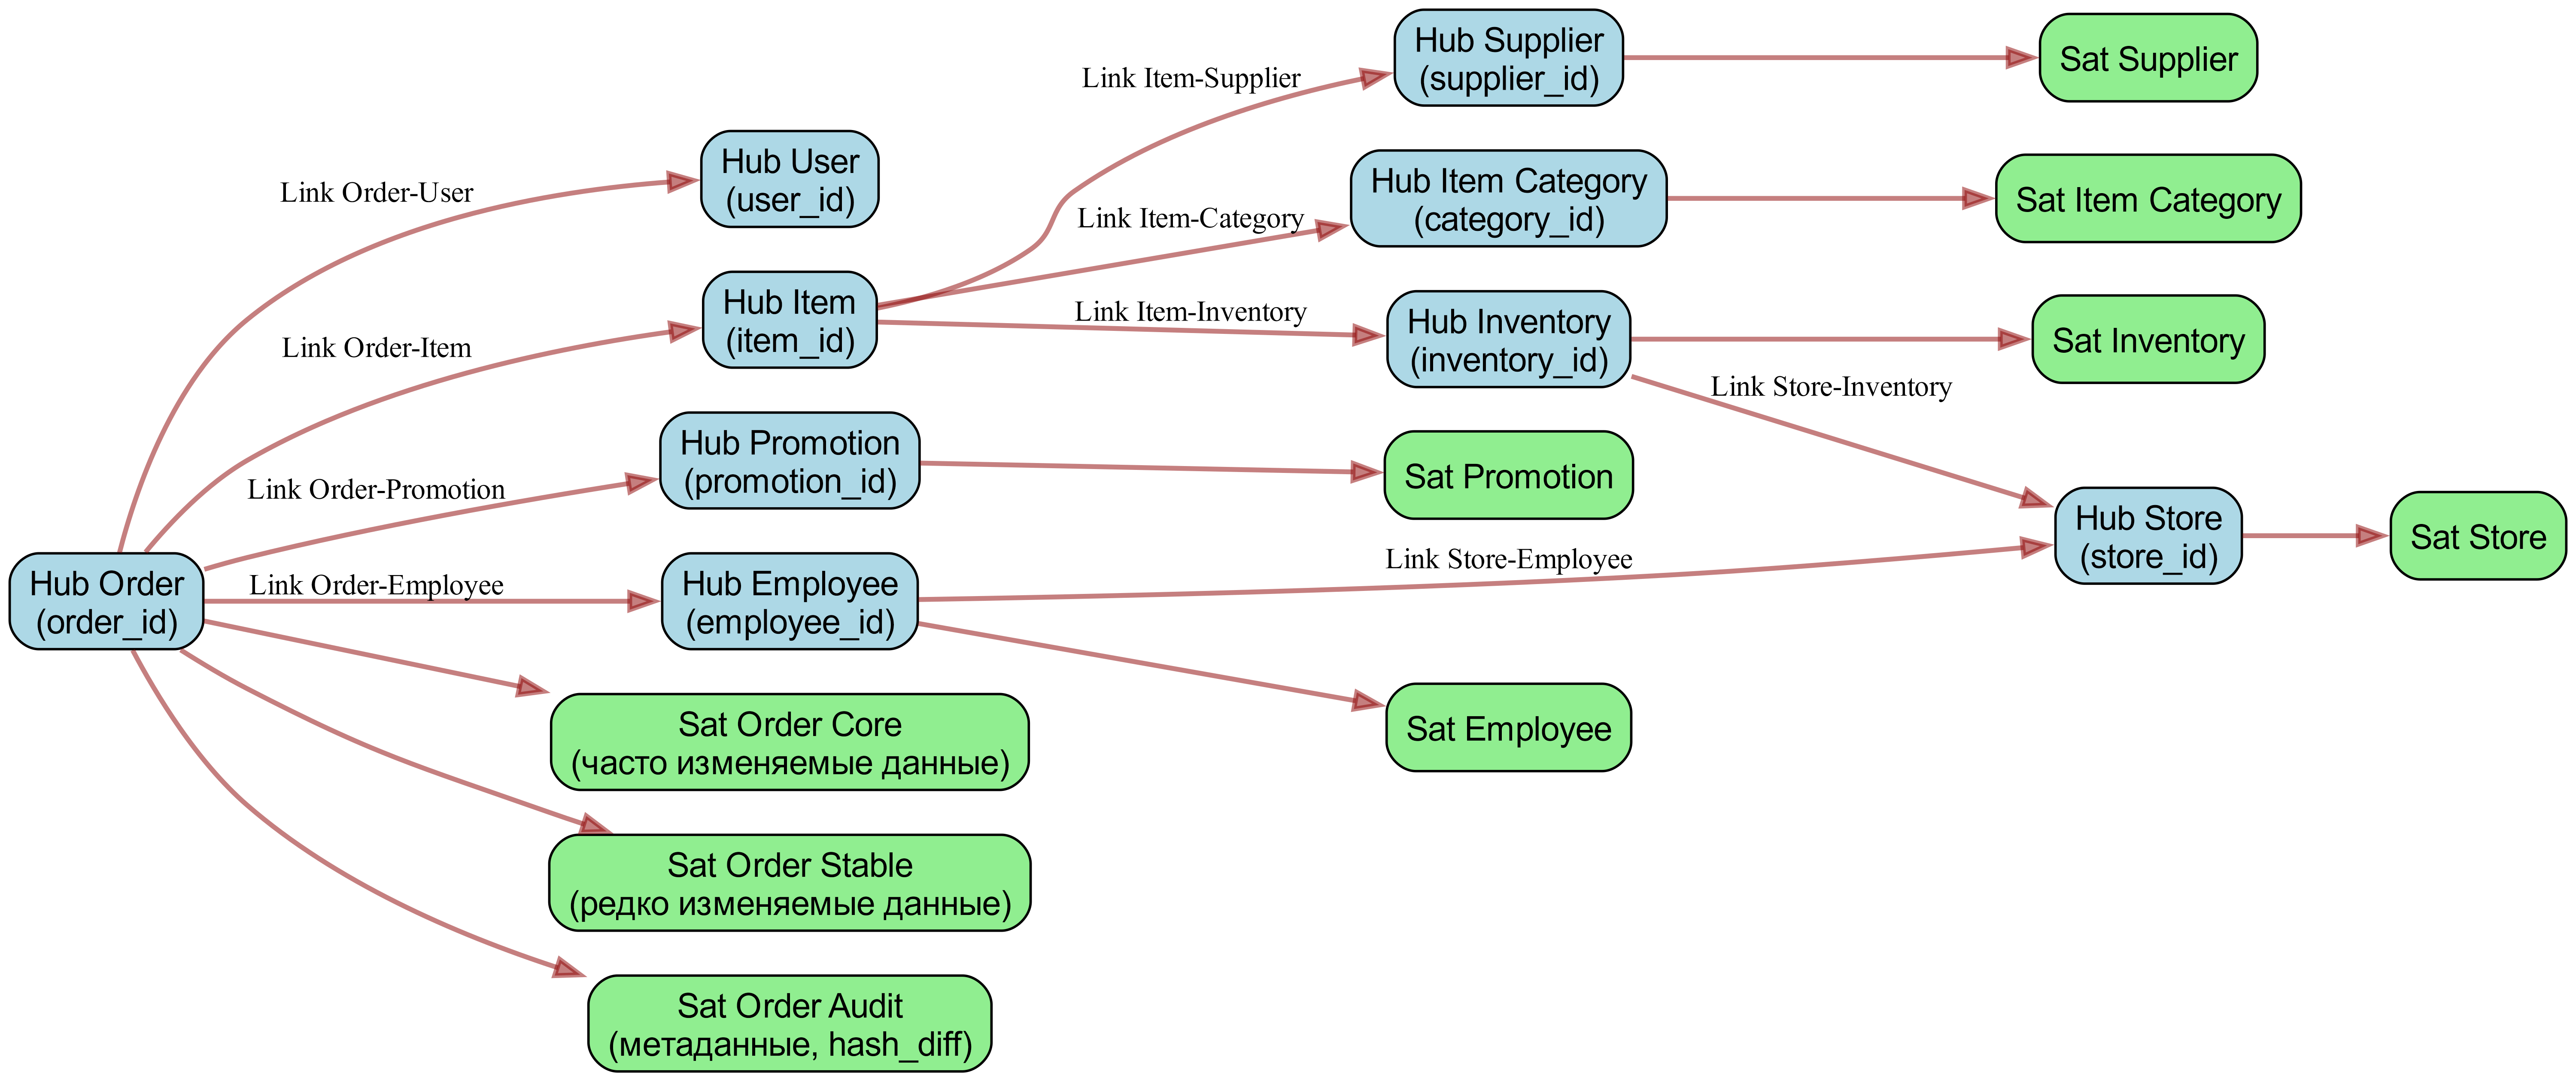

'data_vault_schema.png'

In [21]:
from graphviz import Digraph
from IPython.display import Image, display

# Создаем объект графа
dot = Digraph(comment='Data Vault Schema for Stationery Stores', format='png')
dot.attr(rankdir='LR')
dot.graph_attr.update(size="10,10!", dpi="600")

# Определяем стили для хабов, сателлитов и связей (links)
hub_style = {'shape': 'box', 'style': 'rounded,filled', 'fillcolor': 'lightblue', 'fontname': 'Helvetica'}
sat_style = {'shape': 'box', 'style': 'rounded,filled', 'fillcolor': 'lightgreen', 'fontname': 'Helvetica'}
# Стиль для связей: темно-красный с полупрозрачностью и увеличенной толщиной
link_style = {'color': '#8B000080', 'penwidth': '2'}

# ============================================================================
# 1. Hubs (Уникальные бизнес-сущности)
# ============================================================================
dot.node('HO', 'Hub Order\n(order_id)', **hub_style)
dot.node('HU', 'Hub User\n(user_id)', **hub_style)
dot.node('HI', 'Hub Item\n(item_id)', **hub_style)
dot.node('HP', 'Hub Promotion\n(promotion_id)', **hub_style)
dot.node('HE', 'Hub Employee\n(employee_id)', **hub_style)
dot.node('HSup', 'Hub Supplier\n(supplier_id)', **hub_style)
dot.node('HSt', 'Hub Store\n(store_id)', **hub_style)
dot.node('HIC', 'Hub Item Category\n(category_id)', **hub_style)
dot.node('HInv', 'Hub Inventory\n(inventory_id)', **hub_style)

# ============================================================================
# 2. Satellites (Хранят описательные и временные атрибуты)
# ============================================================================
# Для Hub Order: три сателлита
dot.node('SOC', 'Sat Order Core\n(часто изменяемые данные)', **sat_style)
dot.node('SOS', 'Sat Order Stable\n(редко изменяемые данные)', **sat_style)
dot.node('SOA', 'Sat Order Audit\n(метаданные, hash_diff)', **sat_style)

# Для Hub Promotion
dot.node('SP', 'Sat Promotion', **sat_style)
# Для Hub Employee
dot.node('SE', 'Sat Employee', **sat_style)
# Для Hub Supplier
dot.node('SSup', 'Sat Supplier', **sat_style)
# Для Hub Store
dot.node('SSt', 'Sat Store', **sat_style)
# Для Hub Item Category
dot.node('SIC', 'Sat Item Category', **sat_style)
# Для Hub Inventory
dot.node('SInv', 'Sat Inventory', **sat_style)

# ============================================================================
# 3. Связи между Hubs и их Satellites
# ============================================================================
# Hub Order -> его сателлиты
dot.edge('HO', 'SOC', **link_style)
dot.edge('HO', 'SOS', **link_style)
dot.edge('HO', 'SOA', **link_style)
# Остальные связи: связываем каждый хаб с его сателлитом (если применимо)
dot.edge('HP', 'SP', **link_style)
dot.edge('HE', 'SE', **link_style)
dot.edge('HSup', 'SSup', **link_style)
dot.edge('HSt', 'SSt', **link_style)
dot.edge('HIC', 'SIC', **link_style)
dot.edge('HInv', 'SInv', **link_style)

# ============================================================================
# 4. Link-сущности (связи между хабами)
# ============================================================================
# link_order_user: связь заказа и пользователя
dot.edge('HO', 'HU', label='Link Order-User', fontsize='12', **link_style)
# link_order_item: связь заказа и товара
dot.edge('HO', 'HI', label='Link Order-Item', fontsize='12', **link_style)
# link_order_employee: связь заказа и сотрудника
dot.edge('HO', 'HE', label='Link Order-Employee', fontsize='12', **link_style)
# link_product_supplier: связь товара и поставщика
dot.edge('HI', 'HSup', label='Link Item-Supplier', fontsize='12', **link_style)
# link_store_employee: связь сотрудника и магазина
dot.edge('HE', 'HSt', label='Link Store-Employee', fontsize='12', **link_style)
# link_item_category: связь товара и категории
dot.edge('HI', 'HIC', label='Link Item-Category', fontsize='12', **link_style)
# link_store_inventory: связь инвентаря и магазина
dot.edge('HInv', 'HSt', label='Link Store-Inventory', fontsize='12', **link_style)
# link_item_inventory: связь товара и инвентаря
dot.edge('HI', 'HInv', label='Link Item-Inventory', fontsize='12', **link_style)
# link_order_promotion: связь заказа и промо-акции
dot.edge('HO', 'HP', label='Link Order-Promotion', fontsize='12', **link_style)

# ============================================================================
# Генерация и отображение графа в Jupyter Notebook
# ============================================================================
img_bytes = dot.pipe(format='png')
display(Image(img_bytes))

# Сохраняем и отображаем граф
dot.render('data_vault_schema', view=True)